In [1]:
import os
import sys
import time
import datetime
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import re
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
sys.path.append('/Users/yantingting/PycharmProjects/modeling/')
import database_conncet as data_con
import data_processing as dp
import summary_statistics as ss
from data_io_utils import *

In [2]:
date = datetime.date.today().strftime('%m-%d')
file_path= os.path.join('/Users/yantingting/Seafile/风控/模型/10 印尼/低费率测试/ytt/', date)
if not os.path.exists(file_path):
    os.mkdir(file_path)

# 渠道代码

In [3]:
query4 = '''
SELECT
        c.media_source,
        c.channel,
        date(c.create_time) as reg_date,
		c.level_group as level_group,
		c.campaign,
		substring(c.create_time::varchar, 1, 13) as createtime,
		count(distinct c.id) as customer_install ,
		count(distinct l.id) as application ,
		count(distinct case when effective_date >= '2020-01-07' and loan_status not in ('DENIED', 'RESCIND', 'APPROVING', 'CREATED') then l.id else null end)as fangkuan
	from dw_gocash_go_cash_loan_gocash_core_customer c
	left join dw_gocash_go_cash_loan_gocash_core_loan l on c.id = l.customer_id
	where	c.device = 'ANDROID'
	and c.level_group != ''
	and c.product_code='UKU'
    and c.level_group_time >= '2020-01-16 21:48:50'
	group by 1,2,3,4,5,6
union all 
SELECT
        c.media_source,
        c.channel,
        date(c.create_time) as reg_date,
		'对照组' as level_group,
		c.campaign,
		substring(c.create_time::varchar, 1, 13) as createtime,
		count(distinct c.id) as customer_install ,
		count(distinct l.id) as application ,
		count(distinct case when effective_date >= '2020-01-07' and loan_status not in ('DENIED', 'RESCIND', 'APPROVING', 'CREATED') then l.id else null end)as fangkuan
	from dw_gocash_go_cash_loan_gocash_core_customer c
	left join dw_gocash_go_cash_loan_gocash_core_loan l on c.id = l.customer_id
	where c.device = 'ANDROID'
	and c.level_group = ''
	and c.product_code='UKU'
	and date(c.create_time)>='2020-01-10' and  date(c.create_time)<='2020-01-16'
	group by 1,2,3,4,5,6
'''

In [4]:
df4 = data_con.database_gn(query4)
save_data_to_pickle(df4, file_path, '渠道转化.pkl')
df4.shape

Successful connection


(166756, 9)

# 渠道分析

In [5]:
df4 = load_data_from_pickle( file_path, '渠道转化.pkl')
df4['media_source'] = df4.apply(lambda x: x['channel'] if x['media_source']=='' else 'cashcash_int' if x['channel'] == 'cashcash_int' else x['media_source'],axis = 1)
cols_meiti = ['Facebook Ads','GooglePlay','googleadwords_int','organic']
cols_bd = ['kreditpedia','cashcash_int','affle_int','xyads_int','dokteruang_int','estrend','unions','intellectads_int',
           'superads_int','tyroo_int','pokktperformance_int','Kredit All','invite_friend_activity_01','inmobi_int']
df4['source'] = df4['media_source'].apply(lambda x:x if x in cols_meiti else 'BD' if x in cols_bd else 'else')

cols2 = ['uku-fb-sm-MIN4-0115-cs',  'UKU-FB-sm-MIN2-M-0113',  'UKU-FB-sm-MIN2-V-0113',  'UKU-FB-sm-dl-02-fk-M-0114',
         'UKU Install 02','UKU-FB-sm-MIN2-M-1127','uku-tt-sm-MIN1-0626-2','UKU-MIN2-0424-1', 'UKU-MIN2-az-fk02',
         'UKU-MIN2-0423-1']
df4['ads'] = df4['campaign'].apply(lambda x:x if x in cols2 else 'else')
df4['source_flag'] = df4.apply(lambda x: '非调整渠道' if ((x['ads'] == 'else')&(x['source']!='BD')) else '调整渠道',axis = 1)
df4.to_excel(os.path.join(file_path,'渠道.xlsx'))
df4.shape

(166756, 12)

In [ ]:
调整渠道 vs 非调整渠道

In [26]:
df4_1 = df4[(df4['level_group'] != 'OneControlGroup')&(df4['level_group'] != 'OneTest1')
            &(df4['level_group'] != 'OneTest2')&(df4['level_group'] != '对照组')]
frame1 = pd.pivot_table(df4_1,index = ('source', 'level_group'), columns = 'source_flag',
               values=('customer_install','application','fangkuan'),aggfunc='sum',
              fill_value=0)
frame1['调整渠道占比'] = frame1[('application', '调整渠道')]/frame1['application'].apply(lambda x:x.sum(),axis = 1)
frame1[('注册到申请','调整渠道')] = frame1[('application', '调整渠道')]/frame1['customer_install', '调整渠道']
frame1[('注册到申请','非调整渠道')] = frame1[('application', '非调整渠道')]/frame1['customer_install', '非调整渠道']
frame1[('申请到放款','调整渠道')] = frame1[('fangkuan', '调整渠道')]/frame1[('application', '调整渠道')]
frame1[('申请到放款','非调整渠道')] = frame1[('fangkuan', '非调整渠道')]/frame1[('application', '非调整渠道')]
frame1[('注册到放款','调整渠道')] = frame1[('fangkuan', '调整渠道')]/frame1[('customer_install', '调整渠道')]
frame1[('注册到放款','非调整渠道')] = frame1[('fangkuan', '非调整渠道')]/frame1[('customer_install', '非调整渠道')]
frame1 = frame1.fillna(np.nan)
frame1
t1, p1 = stats.ttest_ind(frame1[('注册到申请','调整渠道')][~frame1[('注册到申请','调整渠道')].isna()],
                         frame1[('注册到申请','非调整渠道')][~frame1[('注册到申请','非调整渠道')].isna()])
print("注册到申请 t = " + str(t1))
print("注册到申请 p = " + str(p1))

t2, p2 = stats.ttest_ind(frame1[('申请到放款','调整渠道')][~frame1[('申请到放款','调整渠道')].isna()],
                         frame1[('申请到放款','非调整渠道')][~frame1[('申请到放款','非调整渠道')].isna()])
print("申请到放款 t = " + str(t2))
print("申请到放款 p = " + str(p2))

t3, p3 = stats.ttest_ind(frame1[('注册到放款','调整渠道')][~frame1[('注册到放款','调整渠道')].isna()],
                         frame1[('注册到放款','非调整渠道')][~frame1[('注册到放款','非调整渠道')].isna()])
print("注册到放款 t = " + str(t3))
print("注册到放款 p = " + str(p3))

frame1.to_excel(os.path.join(file_path,'temp1.xlsx'))


application        customer_install         \
source_flag                           调整渠道  非调整渠道             调整渠道  非调整渠道   
source            level_group                                               
BD                ControlGroup         816      0             1489      0   
                  Test1               2309      0             4249      0   
                  Test2               2717      0             4875      0   
                  Test3               2726      0             4933      0   
                  Test4               3183      0             5607      0   
Facebook Ads      ControlGroup          79    701              109   1250   
                  Test1                168   1507              241   2941   
                  Test2                200   1691              287   3268   
                  Test3                188   1860              288   3311   
                  Test4                207   2034              327   3677   
GooglePlay        ControlGroup           0    470                0    801   
                  Test1                  0   1572                0   2959   
                  Test2                  0   1776                0   3361   
                  Test3                  0   1820                0   3467   
                  Test4                  0   2145                0   4022   
else              ControlGroup           0    241                0    438   
                  Test1                  0    648                0   1344   
                  Test2                  0    718                0   1501   
                  Test3                  0    764                0   1501   
                  Test4                  0    878                0   1703   
googleadwords_int ControlGroup         550   3466              953   5988   
                  Test1               1192   7643             2186  13863   
                  Test2               1386   8636             2387  15397   
                  Test3               1391   8868             2438  15379   
                  Test4               1579  10148             2732  17281   
organic           ControlGroup           0   1181                0   2311   
                  Test1                  0   2572                0   5737   
                  Test2                  0   2905                0   6397   
                  Test3                  0   2960                0   6332   
                  Test4                  0   3515                0   7252   

                               fangkuan          调整渠道占比     注册到申请            \
source_flag                        调整渠道 非调整渠道                调整渠道     非调整渠道   
source            level_group                                                 
BD                ControlGroup      221     0  1.000000  0.548019       NaN   
                  Test1             384     0  1.000000  0.543422       NaN   
                  Test2             483     0  1.000000  0.557333       NaN   
                  Test3             482     0  1.000000  0.552605       NaN   
                  Test4             548     0  1.000000  0.567683       NaN   
Facebook Ads      ControlGroup       26   202  0.101282  0.724771  0.560800   
                  Test1              46   278  0.100299  0.697095  0.512411   
                  Test2              53   284  0.105764  0.696864  0.517442   
                  Test3              57   356  0.091797  0.652778  0.561764   
                  Test4              65   366  0.092369  0.633028  0.553168   
GooglePlay        ControlGroup        0   147  0.000000       NaN  0.586767   
                  Test1               0   274  0.000000       NaN  0.531261   
                  Test2               0   289  0.000000       NaN  0.528414   
                  Test3               0   325  0.000000       NaN  0.524950   
                  Test4               0   366  0.000000       NaN  0.533317   
else              ControlGroup        0    69  0.000000       NaN  

注册到申请 t = 4.608826846419507
注册到申请 p = 4.469292629296954e-05
申请到放款 t = -0.22923346339763082
申请到放款 p = 0.8199168095610875
注册到放款 t = 1.0049695110207522
注册到放款 p = 0.32126832875008193


In [ ]:
Control vs. Test1

In [11]:
df6 = df4[(df4['level_group'] == 'ControlGroup')|(df4['level_group'] == 'Test1')]
frame6 = pd.pivot_table(df6, index = ['source', 'source_flag'], columns = 'level_group',
                        values= ['customer_install','application', 'fangkuan'],aggfunc='sum',fill_value=0)
frame6[('注册到申请','ControlGroup')] = frame6[('application', 'ControlGroup')]/frame6['customer_install', 'ControlGroup']
frame6[('注册到申请','Test1')] = frame6[('application', 'Test1')]/frame6['customer_install', 'Test1']
frame6[('申请到放款','ControlGroup')] = frame6[('fangkuan', 'ControlGroup')]/frame6[('application', 'ControlGroup')]
frame6[('申请到放款','Test1')] = frame6[('fangkuan', 'Test1')]/frame6[('application', 'Test1')]
frame6
t1, p1 = stats.ttest_ind(frame6.注册到申请.ControlGroup,
                         frame6.注册到申请.Test1)
print("注册到申请 t = " + str(t1))
print("注册到申请 p = " + str(p1))

t2, p2 = stats.ttest_ind(frame6.申请到放款.ControlGroup,
                         frame6.申请到放款.Test1)
print("申请到放款 t = " + str(t2))
print("申请到放款 p = " + str(p2))
frame6.to_excel(os.path.join(file_path, 'temp3.xlsx'))

application       customer_install         \
level_group                   ControlGroup Test1     ControlGroup  Test1   
source            source_flag                                              
BD                调整渠道                 816  2309             1489   4249   
Facebook Ads      调整渠道                  79   168              109    241   
                  非调整渠道                701  1507             1250   2941   
GooglePlay        非调整渠道                470  1572              801   2959   
else              非调整渠道                241   648              438   1344   
googleadwords_int 调整渠道                 550  1192              953   2186   
                  非调整渠道               3466  7643             5988  13863   
organic           非调整渠道               1181  2572             2311   5737   

                                  fangkuan              注册到申请            \
level_group                   ControlGroup Test1 ControlGroup     Test1   
source            source_flag                                             
BD                调整渠道                 221   384     0.548019  0.543422   
Facebook Ads      调整渠道                  26    46     0.724771  0.697095   
                  非调整渠道                202   278     0.560800  0.512411   
GooglePlay        非调整渠道                147   274     0.586767  0.531261   
else              非调整渠道                 69   143     0.550228  0.482143   
googleadwords_int 调整渠道                 109   104     0.577125  0.545288   
                  非调整渠道               1154  1653     0.578824  0.551324   
organic           非调整渠道                272   440     0.511034  0.448318   

                                     申请到放款            
level_group                   ControlGroup     Test1  
source            source_flag                         
BD                调整渠道            0.270833  0.166306  
Facebook Ads      调整渠道            0.329114  0.273810  
                  非调整渠道           0.288160  0.184472  
GooglePlay        非调整渠道           0.312766  0.174300  
else              非调整渠道           0.286307  0.220679  
googleadwords_int 调整渠道            0.198182  0.087248  
                  非调整渠道           0.332949  0.216276  
organic           非调整渠道           0.230313  0.171073

注册到申请 t = 1.1928640184563242
注册到申请 p = 0.2527477401334926
申请到放款 t = 3.7215879174437863
申请到放款 p = 0.0022778767448105738


# 模型分code

In [3]:
query2 = '''
select
t1.media_source,
t1.channel,
date(t1.create_time) as reg_date,
t1.level_group as level_group,
t1.campaign,
r.newusermodelscorev5,
count(distinct t1.id) as customer_install ,
count(distinct t2.id) as application ,
count(distinct case when effective_date >= '2020-01-07' and loan_status not in ('DENIED', 'RESCIND', 'APPROVING', 'CREATED') then t2.id else null end)as fangkuan
from dw_gocash_go_cash_loan_gocash_core_customer t1
left join dw_gocash_go_cash_loan_gocash_core_loan t2 on	t1.id = t2.customer_id
left join rt_risk_mongo_gocash_installmentriskcontrolresult r on t2.id::varchar = r.loanid
left join risk_mongo_gocash_installmentriskcontrolparams p on p.riskno = r.riskno
where t1.device = 'ANDROID'  and product_code = 'UKU' and (r.newusermodelscorev5 is not null and r.newusermodelscorev5<>'')
and t1.level_group <> '' and t1.level_group is not null and t1.level_group_time >= '2020-01-16 21:48:50'
group by 1,2,3,4,5,6
union all
select
t1.media_source,
t1.channel,
date(t1.create_time) as reg_date,
'对照组' as level_group,
t1.campaign,
r.newusermodelscorev5,
count(distinct t1.id) as customer_install ,
count(distinct t2.id) as application ,
count(distinct case when effective_date >= '2020-01-07' and loan_status not in ('DENIED', 'RESCIND', 'APPROVING', 'CREATED') then t2.id else null end)as fangkuan
from dw_gocash_go_cash_loan_gocash_core_customer t1
left join dw_gocash_go_cash_loan_gocash_core_loan t2 on	t1.id = t2.customer_id
left join rt_risk_mongo_gocash_installmentriskcontrolresult r on t2.id::varchar = r.loanid
left join risk_mongo_gocash_installmentriskcontrolparams p on p.riskno = r.riskno
where t1.device = 'ANDROID'  and product_code = 'UKU' and (r.newusermodelscorev5 is not null and r.newusermodelscorev5<>'')
and t1.level_group = '' 
and date(t1.create_time)>='2020-01-10' and  date(t1.create_time)<='2020-01-16'
group by 1,2,3,4,5,6

'''

In [ ]:
df2 = data_con.database_gn(query2)
save_data_to_pickle(df2, file_path, '模型监控.pkl')
df2.shape

Successful connection


# 模型分分析

In [38]:
df2 = load_data_from_pickle( file_path, '模型监控.pkl')
df2 = df2[(df2['level_group'] != 'OneControlGroup') & (df2['level_group'] != 'OneTest1') & (df2['level_group'] != 'OneTest2')]
df2 = df2[df2['reg_date']>=pd.to_datetime('2020-01-10')]
df2.shape
df2['media_source'] = df2.apply(lambda x: x['channel'] if x['media_source']=='' else 'cashcash_int' if x['channel'] == 'cashcash_int' else x['media_source'],axis = 1)
cols_meiti = ['Facebook Ads','GooglePlay','googleadwords_int','organic']
cols_bd = ['kreditpedia','cashcash_int','affle_int','xyads_int','dokteruang_int','estrend','unions','intellectads_int',
           'superads_int','tyroo_int','pokktperformance_int','Kredit All','invite_friend_activity_01','inmobi_int']
df2['source'] = df2['media_source'].apply(lambda x:x if x in cols_meiti else 'BD' if x in cols_bd else 'else')
cols2 = ['uku-fb-sm-MIN4-0115-cs',  'UKU-FB-sm-MIN2-M-0113',  'UKU-FB-sm-MIN2-V-0113',  'UKU-FB-sm-dl-02-fk-M-0114',
         'UKU Install 02','UKU-FB-sm-MIN2-M-1127','uku-tt-sm-MIN1-0626-2','UKU-MIN2-0424-1', 'UKU-MIN2-az-fk02',
         'UKU-MIN2-0423-1']
df2['ads'] = df2['campaign'].apply(lambda x:x if x in cols2 else 'else')
df2['source_flag'] = df2.apply(lambda x: '非调整渠道' if ((x['ads'] == 'else')&(x['source']!='BD')) else '调整渠道',axis = 1)
df2['newusermodelscorev5'] =df2['newusermodelscorev5'].astype(float)
cut_bin = [-np.Inf, 577.0,594.0,606.0,614.0,622.0,628.0,634.0,641.0,650.0,np.Inf]
df2['scorev5_group'] = pd.cut(df2['newusermodelscorev5'], cut_bin,right = True, precision=0).astype(str)
df2.to_excel(os.path.join(file_path,'模型分.xlsx'), index = False)
df2.head()


(37911, 9)

,media_source,channel,reg_date,level_group,campaign,newusermodelscorev5,customer_install,application,fangkuan,source,ads,source_flag,scorev5_group
3876,GooglePlay,GooglePlay,2020-01-10,ControlGroup,,605.0,1,1,0,GooglePlay,else,非调整渠道,"(594.0, 606.0]"
3877,GooglePlay,GooglePlay,2020-01-10,Test1,,641.0,1,1,1,GooglePlay,else,非调整渠道,"(634.0, 641.0]"
3878,GooglePlay,GooglePlay,2020-01-10,Test2,,577.0,1,1,0,GooglePlay,else,非调整渠道,"(-inf, 577.0]"
3879,GooglePlay,GooglePlay,2020-01-10,Test2,,594.0,1,1,0,GooglePlay,else,非调整渠道,"(577.0, 594.0]"
3880,GooglePlay,GooglePlay,2020-01-10,Test2,,643.0,1,1,1,GooglePlay,else,非调整渠道,"(641.0, 650.0]"


In [ ]:
fig_path = os.path.join(file_path, 'fig')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

In [ ]:
不同渠道同一组模型分分布

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'ControlGroup 累计分布')

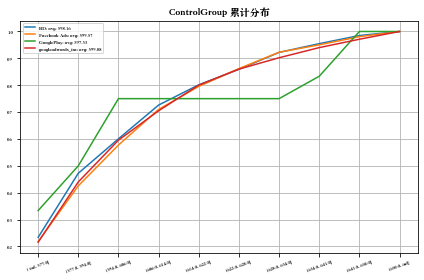

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'Test1 累计分布')

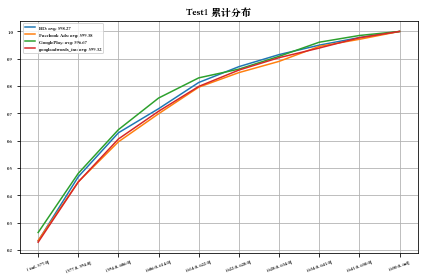

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'Test2 累计分布')

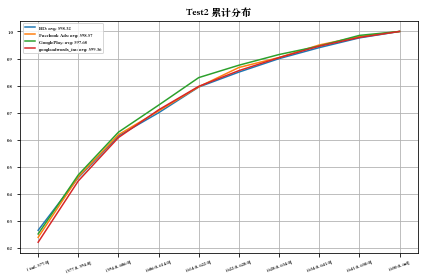

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'Test3 累计分布')

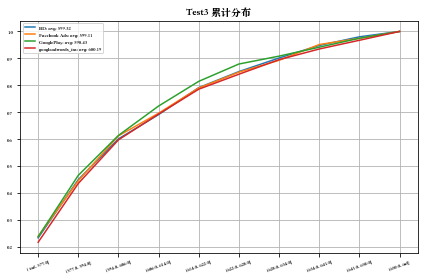

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'Test4 累计分布')

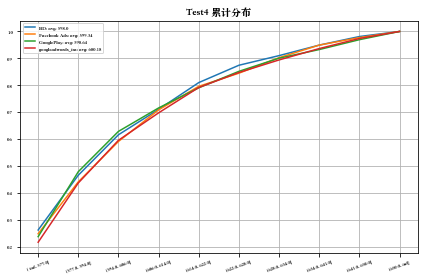

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, '对照组 累计分布')

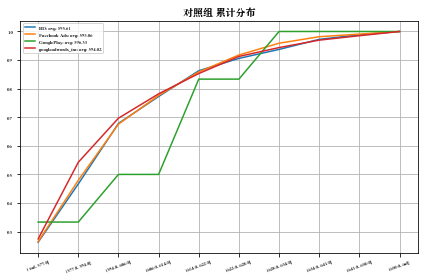

In [35]:
group_list = df2['level_group'].unique().tolist()
for group in group_list:
    df_temp = df2[df2['level_group'] == group] 
    temp2 = pd.pivot_table(df_temp,index = 'scorev5_group',columns = 'source',values='application',aggfunc='sum', fill_value=0)
    for cols3 in temp2.columns.tolist():
        all = temp2[cols3].sum()
        temp2[cols3] = temp2[cols3].cumsum(0)/all
    col_list = ['BD','Facebook Ads','GooglePlay','googleadwords_int']
    col_legend = []
    for cols2 in col_list:
        plt.plot(temp2.index, temp2[cols2])
        df_temp1 = df_temp[df_temp['source'] == cols2]
        avg = round((df_temp1['newusermodelscorev5']*df_temp1['application']).sum()/df_temp1['application'].sum(),2)
        col_legend.append(cols2 + ': avg: %s'%avg)
    plt.legend(col_legend,fontsize=5)
    plt.xticks(rotation=20, fontsize=5)
    plt.tick_params(labelsize=5)
    plt.title(u'%s 累计分布'%group,fontsize=10)
    plt.grid()
    plt.tight_layout();
    plt.savefig(os.path.join(fig_path, group +' 累计分布' +'.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
    plt.show()
    plt.close();

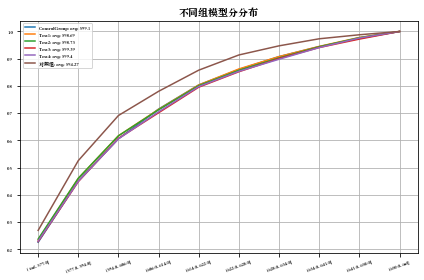

In [36]:
frame = pd.pivot_table(df2,index = 'scorev5_group',columns = 'level_group',values='application',aggfunc='sum')
for cols in frame.columns.tolist():
    all = frame[cols].sum()
    frame[cols] = frame[cols].cumsum(0)/all
col_list = ['ControlGroup', 'Test1','Test2','Test3','Test4','对照组']
# col_list = ['ControlGroup', 'Test1','Test2','Test3','Test4']
col_legend = []
for cols in col_list:
    plt.plot(frame.index, frame[cols])
    df_temp = df2[df2['level_group'] == cols]
    avg = round((df_temp['newusermodelscorev5']*df_temp['application']).sum()/df_temp['application'].sum(),2)
    col_legend.append(cols + ': avg: %s'%avg)
 
plt.legend(col_legend,fontsize=5)
plt.xticks(rotation=20, fontsize=5)
plt.tick_params(labelsize=5)
plt.title(u'不同组模型分分布',fontsize = 10)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(fig_path, '不同组模型分分布' + '.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show();
plt.close();



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'GooglePlay 累计分布')

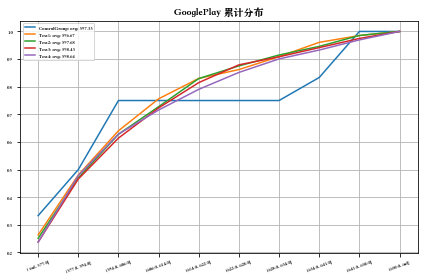

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'else 累计分布')

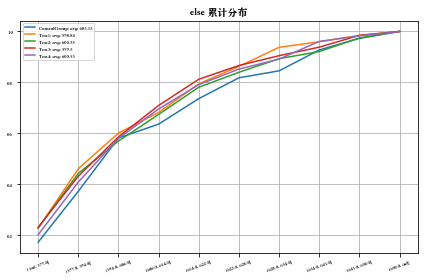

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'BD 累计分布')

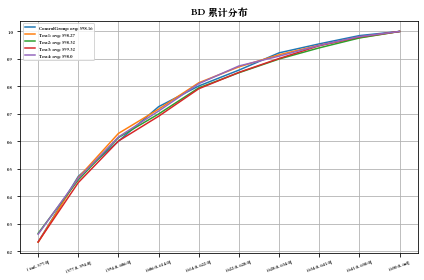

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'Facebook Ads 累计分布')

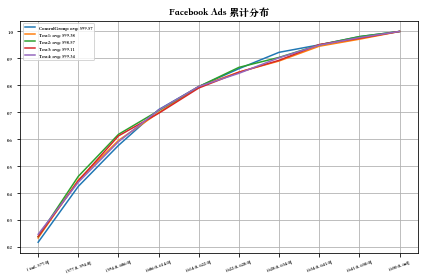

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'googleadwords_int 累计分布')

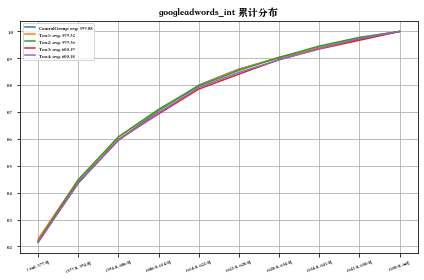

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'organic 累计分布')

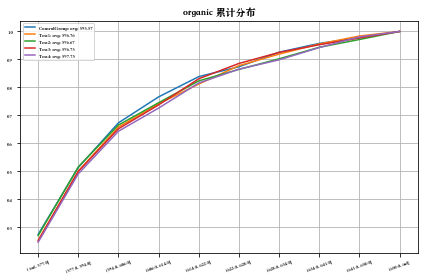

In [97]:
# 累计分布 
df2 = df2[df2['reg_date']>=pd.to_datetime('2020-01-10')]
source_list = df2['source'].unique().tolist()
for qd in source_list:
    df_temp = df2[df2['source'] == qd] 
    temp2 = pd.pivot_table(df_temp,index = 'scorev5_group',columns = 'level_group',values='application',aggfunc='sum', fill_value=0)
    for cols3 in temp2.columns.tolist():
        all = temp2[cols3].sum()
        temp2[cols3] = temp2[cols3].cumsum(0)/all
    col_list = ['ControlGroup','Test1','Test2','Test3','Test4']
    col_legend = []
    for cols2 in col_list:
        plt.plot(temp2.index, temp2[cols2])
        df_temp1 = df_temp[df_temp['level_group'] == cols2]
        avg = round((df_temp1['newusermodelscorev5']*df_temp1['application']).sum()/df_temp1['application'].sum(),2)
        col_legend.append(cols2 + ': avg: %s'%avg)
    plt.legend(col_legend,fontsize=5)
    plt.xticks(rotation=20, fontsize=5)
    plt.tick_params(labelsize=5)
    plt.title(u'%s 累计分布'%qd,fontsize=10)
    plt.grid()
    plt.tight_layout();
    plt.savefig(os.path.join(fig_path, qd +' 累计分布' +'.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
    plt.show()
    plt.close();

In [ ]:
对照组 VS control

'ControlGroup'

597.33

'对照组'

596.33

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'GooglePlay 随时间变化')

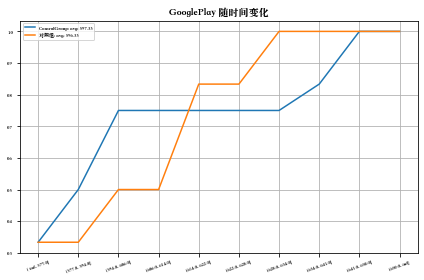

'ControlGroup'

603.15

'对照组'

596.12

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'else 随时间变化')

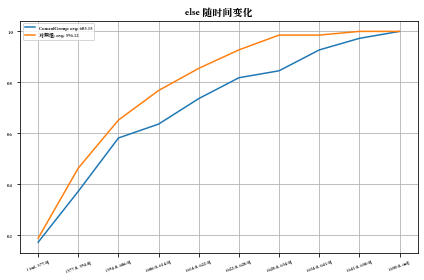

'ControlGroup'

598.16

'对照组'

595.61

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'BD 随时间变化')

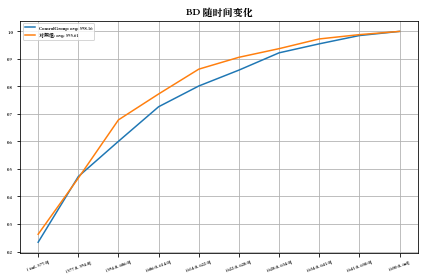

'ControlGroup'

599.57

'对照组'

595.06

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'Facebook Ads 随时间变化')

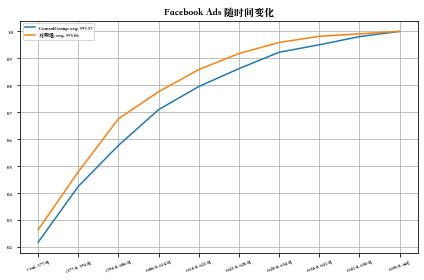

'ControlGroup'

599.88

'对照组'

594.02

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'googleadwords_int 随时间变化')

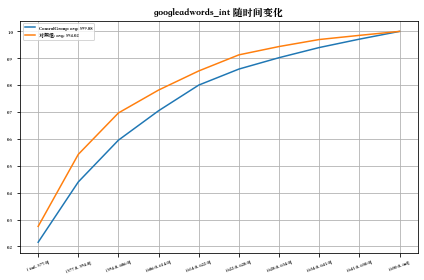

'ControlGroup'

595.57

'对照组'

593.17

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'organic 随时间变化')

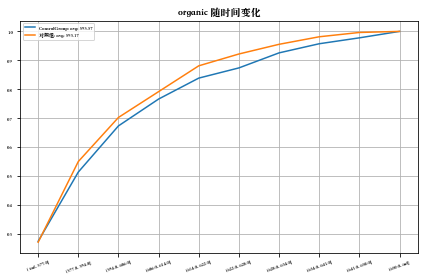

In [43]:
# 累计分布 
df2 = df2[df2['reg_date']>=pd.to_datetime('2020-01-10')]
source_list = df2['source'].unique().tolist()
for qd in source_list:
    df_temp = df2[df2['source'] == qd] 
    temp2 = pd.pivot_table(df_temp,index = 'scorev5_group',columns = 'level_group',values='application',aggfunc='sum', fill_value=0)
    for cols3 in temp2.columns.tolist():
        all = temp2[cols3].sum()
        temp2[cols3] = temp2[cols3].cumsum(0)/all
    col_list = ['ControlGroup','对照组']
    col_legend = []
    for cols2 in col_list:
        cols2
        plt.plot(temp2.index, temp2[cols2])
        df_temp1 = df_temp[df_temp['level_group'] == cols2]
        avg = round((df_temp1['newusermodelscorev5']*df_temp1['application']).sum()/df_temp1['application'].sum(),2)
        avg
        col_legend.append(cols2 + ': avg: %s'%avg)
    plt.legend(col_legend,fontsize=5)
    plt.xticks(rotation=20, fontsize=5)
    plt.tick_params(labelsize=5)
    plt.title(u'%s 随时间变化'%qd,fontsize=10)
    plt.grid()
    plt.tight_layout();
    plt.savefig(os.path.join(fig_path, qd +' 随时间变化' +'.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
    plt.show()
    plt.close();